In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tabulate import tabulate
# 🧩 你的 DualStream_multihead 根目录
BASE_DIR = Path(r"D:/DATA_hao/Kaggle_/csiro-biomass/历史模型")



def show_detail(time_str, tail_window=10, epoch_num=None, min_epoch = 100, show_plot=True):
    exp_dir = BASE_DIR / time_str
    metrics_path = exp_dir / "fold_metrics.xlsx"

    # ===== 1️⃣ 加载文件 =====
    if not metrics_path.exists():
        print(f"❌ 未找到文件: {metrics_path}")
        return
    df = pd.read_excel(metrics_path)
    # print(f"\n\n✅ 已加载: {metrics_path}")
    print(f"📊 数据形状: {df.shape}")

    folds = [1, 2, 3, 4, 5]
    least_limit = min_epoch

    # ===== 2️⃣ 初始化表格（包含平均行） =====
    summary_table = pd.DataFrame({
        "Fold": [f"Fold{f}" for f in folds] + ["Average"],
        "最优Epoch": [np.nan]*6,
        "最优CV": [np.nan]*6,
        "后20平均CV": [np.nan]*6,
        "最后一个CV": [np.nan]*6
    })

    # ===== 3️⃣ 计算每折最佳结果（epoch >= 130） =====
    best_epochs, best_cvs = [], []
    for f in folds:
        col_cv = f"CV_Fold{f}"
        filtered_df = df[df["Epoch"] >= least_limit]
        best_idx = filtered_df[col_cv].idxmax()
        best_epochs.append(int(filtered_df.loc[best_idx, "Epoch"]))
        best_cvs.append(filtered_df.loc[best_idx, col_cv])

    # ===== 4️⃣ 最后 window 个 epoch 的平均 CV =====
    fold_window_means = []
    for f in folds:
        col = f"CV_Fold{f}"
        vals = df[col].dropna()
        if len(vals) >= tail_window:
            mean_val = vals.tail(tail_window).mean()
        elif len(vals) > 0:
            mean_val = vals.mean()
        else:
            mean_val = np.nan
        fold_window_means.append(mean_val)

    # ===== 5️⃣ 每个 Fold 最后一个有效 epoch 的 CV =====
    fold_last_epoch_cv = []
    for f in folds:
        col = f"CV_Fold{f}"
        vals = df[col].dropna()
        last_epoch_cv = vals.iloc[-1] if len(vals) > 0 else np.nan
        fold_last_epoch_cv.append(last_epoch_cv)

    # ===== 6️⃣ 填充表格并计算平均 =====
    for i, f in enumerate(folds):
        summary_table.loc[i, "最优Epoch"] = best_epochs[i]
        summary_table.loc[i, "最优CV"] = best_cvs[i]
        summary_table.loc[i, "后20平均CV"] = fold_window_means[i]
        summary_table.loc[i, "最后一个CV"] = fold_last_epoch_cv[i]

    summary_table.loc[len(folds), "最优CV"] = np.nanmean(best_cvs)
    summary_table.loc[len(folds), "后20平均CV"] = np.nanmean(fold_window_means)
    summary_table.loc[len(folds), "最后一个CV"] = np.nanmean(fold_last_epoch_cv)


    print(f"📊 CV统计汇总表（epoch ≥ {least_limit}）：  {time_str}")
    print(tabulate(summary_table, headers="keys", tablefmt="github", floatfmt=".5f"))
    print("\n")


    # ===== 7️⃣ 可选绘图 =====
    if show_plot:
        # --- CV 曲线 ---
        plt.figure(figsize=(8, 2))
        for f in folds:
            plt.plot(df["Epoch"], df[f"CV_Fold{f}"], label=f"Fold{f}")
        if epoch_num is not None:
            plt.axvspan(epoch_num - tail_window + 1, epoch_num,
                        color="yellow", alpha=0.2,
                        label=f"{epoch_num-tail_window+1}-{epoch_num}")
        plt.title("CV Score per Fold (Epoch)")
        plt.xlabel("Epoch")
        plt.ylabel("CV")
        # plt.ylim([0, 0.8])
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.show()

        # --- 滑动窗口波动 ---
        window_size = tail_window
        plt.figure(figsize=(8, 2))
        for f in folds:
            col = f"CV_Fold{f}"
            diffs, epochs = [], []
            for i in range(window_size - 1, len(df)):
                window = df[col].iloc[i - window_size + 1 : i + 1]
                diffs.append(window.max() - window.min())
                epochs.append(df["Epoch"].iloc[i])
            plt.plot(epochs, diffs, label=f"Fold{f}")
        plt.title(f"Sliding CV Range (Window={window_size} Epochs)")
        plt.xlabel("Epoch")
        plt.ylabel("CV Range (Max-Min)")
        # plt.ylim([0, 0.2])
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.show()

        # --- Train / Val Loss 曲线 ---
        fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
        for f in folds:
            axes[0].plot(df["Epoch"], df[f"Train_Fold{f}"], label=f"Train_Fold{f}")
        axes[0].set_title("Train Loss per Fold")
        # axes[0].set_ylim(0, 0.5)
        axes[0].grid(True, linestyle='--', alpha=0.6)
        axes[0].legend()

        for f in folds:
            axes[1].plot(df["Epoch"], df[f"Val_Fold{f}"], label=f"Val_Fold{f}")
        axes[1].set_title("Validation Loss per Fold")
        axes[1].set_xlabel("Epoch")
        # axes[1].set_ylim(0, 0.5)
        axes[1].grid(True, linestyle='--', alpha=0.6)
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    # ===== 8️⃣ 返回表格数据 =====
    return summary_table



In [ ]:
show_plot = False
table = show_detail("DualStreamMultihead_pipeline_v1_新损失函数新CV", min_epoch = 100, show_plot=show_plot)
table = show_detail("DM_pipeline_原版1113", min_epoch = 120,show_plot=show_plot)
table = show_detail("DM_pipeline_1114原版4070", min_epoch = 100,show_plot=show_plot)
table = show_detail("DM_pipeline_1114原版4070_2测", min_epoch = 100,show_plot=show_plot)


📊 数据形状: (296, 21)
📊 CV统计汇总表（epoch ≥ 100）：  DualStreamMultihead_pipeline_v1_新损失函数新CV
|    | Fold    |   最优Epoch |   最优CV |   后20平均CV |   最后一个CV |
|----|---------|-------------|----------|--------------|--------------|
|  0 | Fold1   |   126.00000 |  0.77561 |      0.72288 |      0.73098 |
|  1 | Fold2   |   144.00000 |  0.80852 |      0.78359 |      0.78792 |
|  2 | Fold3   |   136.00000 |  0.81020 |      0.75184 |      0.75103 |
|  3 | Fold4   |   126.00000 |  0.78706 |      0.74548 |      0.74326 |
|  4 | Fold5   |   191.00000 |  0.72057 |      0.70673 |      0.69404 |
|  5 | Average |   nan       |  0.78039 |      0.74210 |      0.74145 |


📊 数据形状: (284, 21)
📊 CV统计汇总表（epoch ≥ 120）：  DM_pipeline_原版1113
|    | Fold    |   最优Epoch |   最优CV |   后20平均CV |   最后一个CV |
|----|---------|-------------|----------|--------------|--------------|
|  0 | Fold1   |   120.00000 |  0.78922 |      0.71558 |      0.71568 |
|  1 | Fold2   |   132.00000 |  0.81347 |      0.79291 |      0.78702 |
|  2 | Fol

📊 数据形状: (296, 21)
📊 CV统计汇总表（epoch ≥ 100）：  DualStreamMultihead_pipeline_v1_新损失函数新CV
|    | Fold    |   最优Epoch |   最优CV |   后20平均CV |   最后一个CV |
|----|---------|-------------|----------|--------------|--------------|
|  0 | Fold1   |   126.00000 |  0.77561 |      0.72288 |      0.73098 |
|  1 | Fold2   |   144.00000 |  0.80852 |      0.78359 |      0.78792 |
|  2 | Fold3   |   136.00000 |  0.81020 |      0.75184 |      0.75103 |
|  3 | Fold4   |   126.00000 |  0.78706 |      0.74548 |      0.74326 |
|  4 | Fold5   |   191.00000 |  0.72057 |      0.70673 |      0.69404 |
|  5 | Average |   nan       |  0.78039 |      0.74210 |      0.74145 |




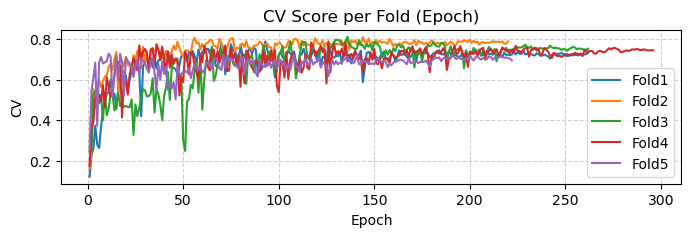

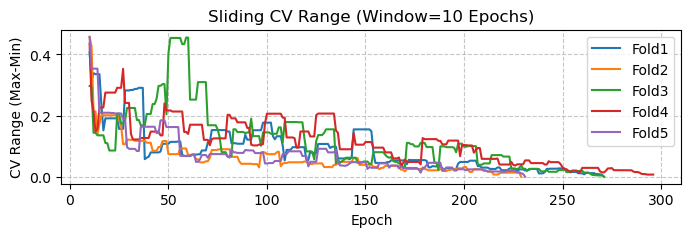

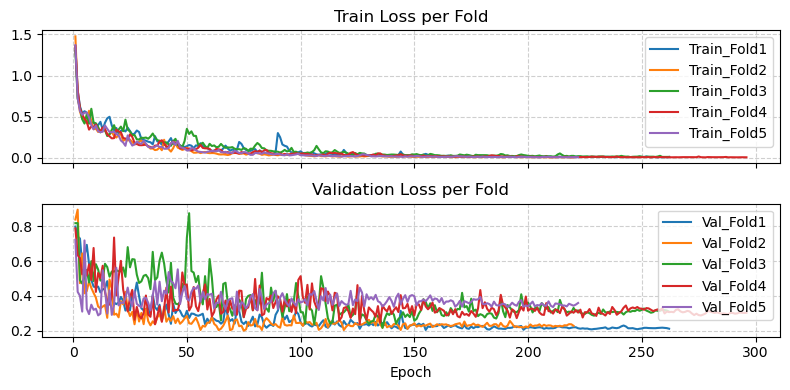

📊 数据形状: (284, 21)
📊 CV统计汇总表（epoch ≥ 120）：  DM_pipeline_原版1113
|    | Fold    |   最优Epoch |   最优CV |   后20平均CV |   最后一个CV |
|----|---------|-------------|----------|--------------|--------------|
|  0 | Fold1   |   120.00000 |  0.78922 |      0.71558 |      0.71568 |
|  1 | Fold2   |   132.00000 |  0.81347 |      0.79291 |      0.78702 |
|  2 | Fold3   |   220.00000 |  0.79309 |      0.77321 |      0.76487 |
|  3 | Fold4   |   157.00000 |  0.75858 |      0.72124 |      0.72364 |
|  4 | Fold5   |   224.00000 |  0.73316 |      0.72428 |      0.72627 |
|  5 | Average |   nan       |  0.77750 |      0.74544 |      0.74350 |




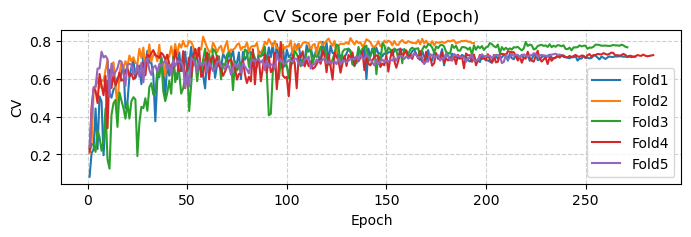

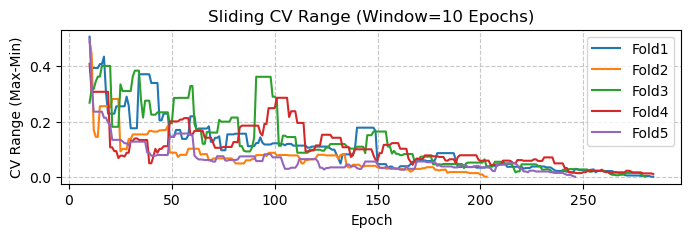

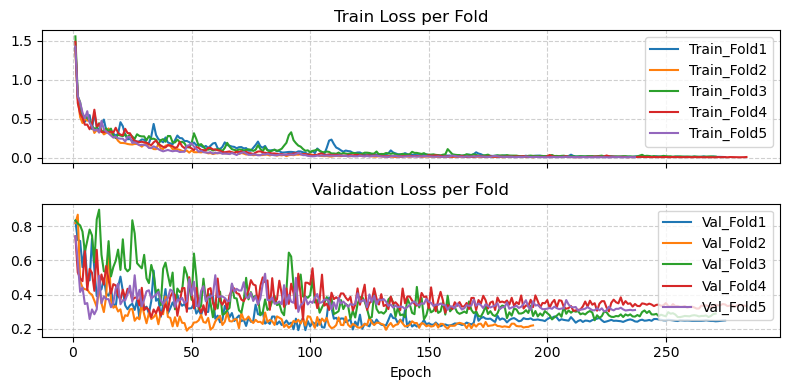

📊 数据形状: (294, 21)
📊 CV统计汇总表（epoch ≥ 100）：  DM_pipeline_1114原版4070
|    | Fold    |   最优Epoch |   最优CV |   后20平均CV |   最后一个CV |
|----|---------|-------------|----------|--------------|--------------|
|  0 | Fold1   |   150.00000 |  0.78914 |      0.75766 |      0.75494 |
|  1 | Fold2   |   197.00000 |  0.81787 |      0.79909 |      0.80204 |
|  2 | Fold3   |   190.00000 |  0.79424 |      0.75201 |      0.74753 |
|  3 | Fold4   |   110.00000 |  0.80257 |      0.75179 |      0.75467 |
|  4 | Fold5   |   205.00000 |  0.72539 |      0.71092 |      0.71203 |
|  5 | Average |   nan       |  0.78584 |      0.75429 |      0.75424 |




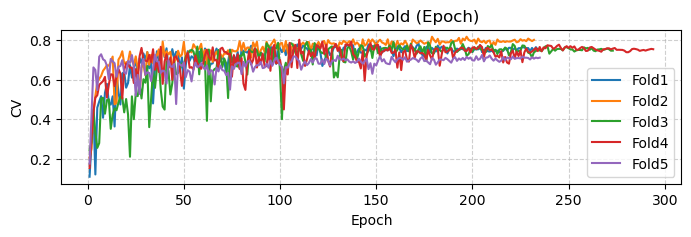

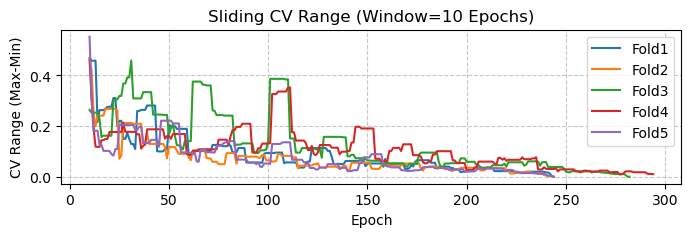

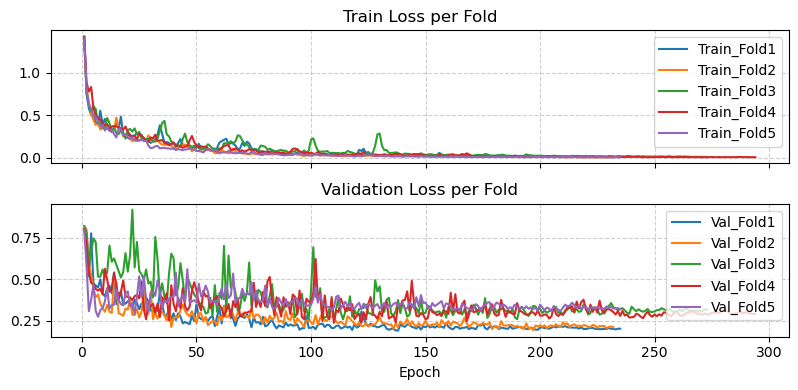

📊 数据形状: (300, 21)
📊 CV统计汇总表（epoch ≥ 100）：  DM_pipeline_1114原版4070_2测
|    | Fold    |   最优Epoch |   最优CV |   后20平均CV |   最后一个CV |
|----|---------|-------------|----------|--------------|--------------|
|  0 | Fold1   |   114.00000 |  0.80992 |      0.77910 |      0.77533 |
|  1 | Fold2   |   106.00000 |  0.79928 |      0.77746 |      0.78087 |
|  2 | Fold3   |   221.00000 |  0.79159 |      0.77354 |      0.77975 |
|  3 | Fold4   |   101.00000 |  0.73807 |      0.67427 |      0.67490 |
|  4 | Fold5   |   186.00000 |  0.72819 |      0.71865 |      0.72311 |
|  5 | Average |   nan       |  0.77341 |      0.74460 |      0.74679 |




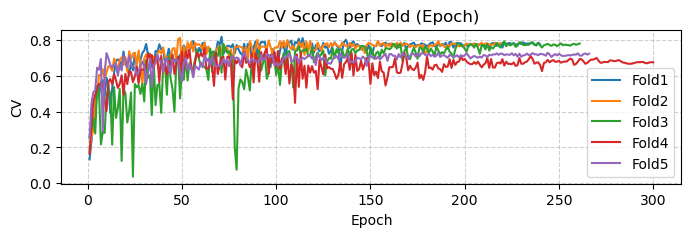

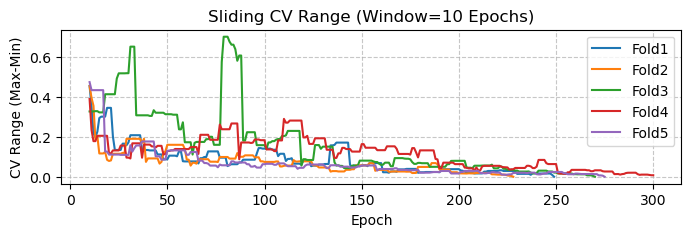

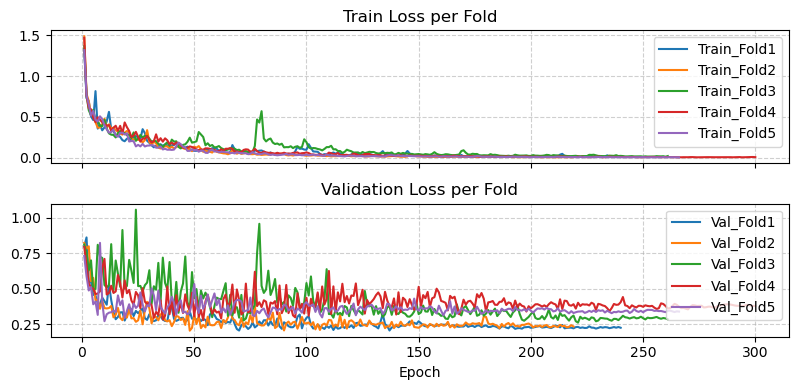

In [5]:
show_plot = True
table = show_detail("DualStreamMultihead_pipeline_v1_新损失函数新CV", min_epoch = 100, show_plot=show_plot)
table = show_detail("DM_pipeline_原版1113", min_epoch = 120,show_plot=show_plot)
table = show_detail("DM_pipeline_1114原版4070", min_epoch = 100,show_plot=show_plot)
table = show_detail("DM_pipeline_1114原版4070_2测", min_epoch = 100,show_plot=show_plot)

In [ ]:
import torch, torchvision; print(torch.__version__, torchvision.__version__)